# Comparison between Hannum and Phenoage Clocks

## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import time
import gzip
import polars as pl
import matplotlib.pyplot as plt
from concrete.ml.sklearn import LinearRegression
from concrete.ml.deployment import FHEModelDev, FHEModelClient, FHEModelServer
from concrete import fhe


## Functions

In [2]:
def load_hannum_coefficients(path, sheet_name=0, intercept=-0.069):
    """
    Load Hannum model coefficients from an Excel file.

    Parameters:
        path (str): Path to the Excel file.
        sheet_name (int or str): Sheet index or name.
        intercept (float): Intercept term to return alongside coefficients.

    Returns:
        coefs_df (pd.DataFrame): CpGs as index and 'Coefficient' column.
        intercept (float): Provided intercept value.
    """
    df = pd.read_excel(path, sheet_name=sheet_name)
    coefs_df = df.set_index("Marker")[["Coefficient"]]

    print(f"Loaded {len(coefs_df)} CpGs and intercept = {intercept:.4f}")
    return coefs_df, intercept

def load_phenoage_coefficients(path, intercept_row_label="Intercept"):
    """
    Load DNAm PhenoAge model coefficients from a CSV.

    Parameters:
        path (str): Path to the CSV file.
        intercept_row_label (str): Label to identify the intercept row.

    Returns:
        coefs_df (pd.DataFrame): CpGs as index and 'Coefficient' column.
        intercept (float): Intercept term from the model.
    """
    df = pd.read_csv(path)

    # Extract intercept
    intercept = df[df["CpG"] == intercept_row_label]["Weight"].values[0]

    # Drop the intercept row and keep CpG + weight
    coefs_df = df[df["CpG"] != intercept_row_label][["CpG", "Weight"]]
    coefs_df = coefs_df.set_index("CpG")
    coefs_df.columns = ["Coefficient"]

    print(f"Loaded {len(coefs_df)} CpGs and intercept = {intercept:.4f}")
    return coefs_df, intercept

def load_betas_aligned(file_path, coefs_df, n_samples=100, impute_value=0.5):
    """
    Load and align beta values to expected CpGs, imputing missing ones.

    Parameters:
        file_path (str): Path to .txt or .gz beta file.
        coefs_df (pd.DataFrame): Coefficient DataFrame with CpGs as index.
        n_samples (int): Number of sample columns to load.
        impute_value (float): Value used for missing CpGs.

    Returns:
        pd.DataFrame: CpG × sample matrix aligned to coefs_df.
    """
    target_cpgs = coefs_df.index.tolist()

    # Load header to get sample names
    with open(file_path, "rt") as f:
        header = f.readline().strip().split('\t')

    id_col = header[0]
    sample_cols = [col for col in header[1:] if "Detection Pval" not in col][:n_samples]
    usecols = [id_col] + sample_cols

    # Read only relevant columns
    df_pl = pl.read_csv(
        file_path,
        separator='\t',
        has_header=True,
        columns=usecols,
        null_values=["NA"]
    )

    # Filter to CpGs available in the file
    df_filtered = df_pl.filter(pl.col(id_col).is_in(target_cpgs)).to_pandas().set_index(id_col)

    # Ensure correct order and impute missing CpGs
    aligned_betas = df_filtered.reindex(coefs_df.index)
    aligned_betas = aligned_betas.fillna(impute_value)

    print(f"Loaded and aligned beta matrix: {aligned_betas.shape[0]} CpGs × {aligned_betas.shape[1]} samples")
    return aligned_betas

def load_chronological_ages_gse55763(file_path):
    """
    Extracts sample IDs and chronological ages from the GSE55763 Series Matrix file.

    Parameters:
        file_path (str): Path to the .txt or .txt.gz file.

    Returns:
        pd.DataFrame: DataFrame with index = sample ID, column = Chronological_Age.
    """
    file_path = os.path.expanduser(file_path)
    open_func = gzip.open if file_path.endswith(".gz") else open

    sample_ids = []
    ages = []

    with open_func(file_path, "rt") as f:
        for line in f:
            if line.startswith("!Sample_title"):
                sample_ids = [
                    s.split(",")[-1].strip().replace('"', '') 
                    for s in line.strip().split('\t')[1:]
                ]
            elif "characteristics_ch1" in line.lower() and "age" in line.lower():
                ages = [
                    float(s.split(":")[-1].strip().replace('"', '')) 
                    for s in line.strip().split('\t')[1:]
                ]

    if not sample_ids or not ages:
        raise ValueError("Could not extract sample IDs or ages from the file.")

    df = pd.DataFrame({"Sample_ID": sample_ids, "Chronological_Age": ages}).set_index("Sample_ID")
    print(f"Parsed {len(df)} ages from GSE55763 metadata.")
    return df

def compare_ages_from_merged_df(merged_df, plot=True):
    """
    Compares Hannum and PhenoAge predictions from merged_df against chronological age.

    Parameters:
    - merged_df (pd.DataFrame): Must include 'Chronological_Age', 'Hannum_Pred', and 'PhenoAge_Pred'.
    - plot (bool): Whether to display the scatter plot.

    Returns:
    - pd.DataFrame: Subset with Sample_ID, Chronological_Age, and both predictions.
    """
    # Check required columns
    required_cols = ["Chronological_Age", "Hannum_Pred", "PhenoAge_Pred"]
    missing = [col for col in required_cols if col not in merged_df.columns]
    if missing:
        raise ValueError(f"Missing columns in merged_df: {missing}")

    # Filter and drop NaNs
    df = merged_df[["Sample_ID"] + required_cols].dropna()
    print(f"Comparison table created with {df.shape[0]} matching samples.")

    if plot:
        plt.figure(figsize=(7, 7))
        plt.scatter(df["Chronological_Age"], df["Hannum_Pred"], alpha=0.6, label="Hannum", color="tab:blue")
        plt.scatter(df["Chronological_Age"], df["PhenoAge_Pred"], alpha=0.6, label="PhenoAge", color="tab:green")
        plt.plot([0, 100], [0, 100], 'k--', label="Ideal match")
        plt.xlabel("Chronological Age")
        plt.ylabel("Predicted Age")
        plt.title("Chronological vs Predicted Epigenetic Ages")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return df


## Load Required Dataframes

In [3]:
# Define file paths
betas_file = os.path.expanduser("~/data/GSE55763_normalized_betas.txt")
hannum_coef_file = os.path.expanduser("~/data/hannum_coefs.xlsx")
phenoage_coef_file = os.path.expanduser("~/phenoage_data/aging-v10i4-101414-supplementary-material-SD2.csv")
sample_metadata_file = os.path.expanduser("~/data/GSE55763_series_matrix.txt.gz")

# Load coefficients and intercepts
hannum_coefs, hannum_intercept = load_hannum_coefficients(hannum_coef_file, )
phenoage_coefs, phenoage_intercept = load_phenoage_coefficients(phenoage_coef_file)

# Combine CpGs from both models (union of indices)
combined_cpgs = hannum_coefs.index.union(phenoage_coefs.index)
combined_coefs = pd.DataFrame(index=combined_cpgs)

# Load samples
aligned_betas = load_betas_aligned(betas_file, combined_coefs, n_samples=500)
ages_df = load_chronological_ages_gse55763(sample_metadata_file)

Loaded 71 CpGs and intercept = -0.0690
Loaded 513 CpGs and intercept = 60.6640
Loaded and aligned beta matrix: 578 CpGs × 500 samples
Parsed 2711 ages from GSE55763 metadata.


In [4]:
# Save ordered list of CpGs from Hannum model
hannum_coefs.index.to_frame().to_csv("hannum_cpgs.csv", index=False, header=False)

# Save ordered list of CpGs from PhenoAge model
phenoage_coefs.index.to_frame().to_csv("phenoage_cpgs.csv", index=False, header=False)


## Create Sample CSV

In [5]:
# Set number of random samples you want
n_samples = 50

# Randomly select sample IDs (columns) from aligned_betas
selected_ids = np.random.choice(aligned_betas.columns, size=n_samples, replace=False)

# Get the CpG beta values for selected samples (transpose: samples × CpGs)
betas_selected = aligned_betas[selected_ids].T.copy()

# Add Sample_ID as column
betas_selected["Sample_ID"] = betas_selected.index

# Join with chronological age info
merged_df = betas_selected.merge(
    ages_df, left_on="Sample_ID", right_index=True, how="left"
)

# Reorder columns: Sample_ID | Chronological_Age | CpGs
columns = ["Sample_ID", "Chronological_Age"] + [col for col in betas_selected.columns if col != "Sample_ID"]
merged_df = merged_df[columns]

# Save to CSV
merged_df.to_csv("sample_test_data.csv", index=False)

print("Saved: sample_test_data.csv")
merged_df.head()


Saved: sample_test_data.csv


,Sample_ID,Chronological_Age,cg00079056,cg00083937,cg00113951,cg00168942,cg00194146,cg00230271,cg00261781,cg00297600,...,cg27187881,cg27244482,cg27367952,cg27440834,cg27493997,cg27514224,cg27626102,cg27655905,ch.13.39564907R,ch.2.30415474F
7471147090_R06C02,7471147090_R06C02,52.1,0.825251,0.683909,0.080444,0.581955,0.172061,0.058270,0.015097,0.690161,...,0.131157,0.680116,0.075272,0.824507,0.194512,0.926329,0.190857,0.073252,0.075451,0.077070
7471147041_R01C02,7471147041_R01C02,65.7,0.836160,0.677696,0.071860,0.530828,0.185723,0.067695,0.000009,0.633223,...,0.095847,0.701503,0.081576,0.845280,0.202862,0.938000,0.160948,0.058734,0.063371,0.075754
7471147036_R04C01,7471147036_R04C01,53.1,0.893819,0.553373,0.085179,0.602461,0.245830,0.043683,0.004476,0.689028,...,0.127138,0.673276,0.078935,0.844360,0.200122,0.939385,0.126320,0.084296,0.073097,0.083279
7471147072_R03C01,7471147072_R03C01,57.9,0.843204,0.592956,0.069063,0.550839,0.225998,0.049370,0.019672,0.729922,...,0.101192,0.707498,0.075371,0.801401,0.229711,0.935284,0.208870,0.080170,0.040209,0.050131
7471147062_R03C02,7471147062_R03C02,65.8,0.852959,0.762942,0.101084,0.528231,0.187850,0.066564,0.019894,0.608723,...,0.125647,0.712905,0.083622,0.835206,0.188081,0.918853,0.139898,0.045753,0.067154,0.094867


## Encrypted Inferenfe of Hannum and Phenoage

Comparison table created with 50 matching samples.


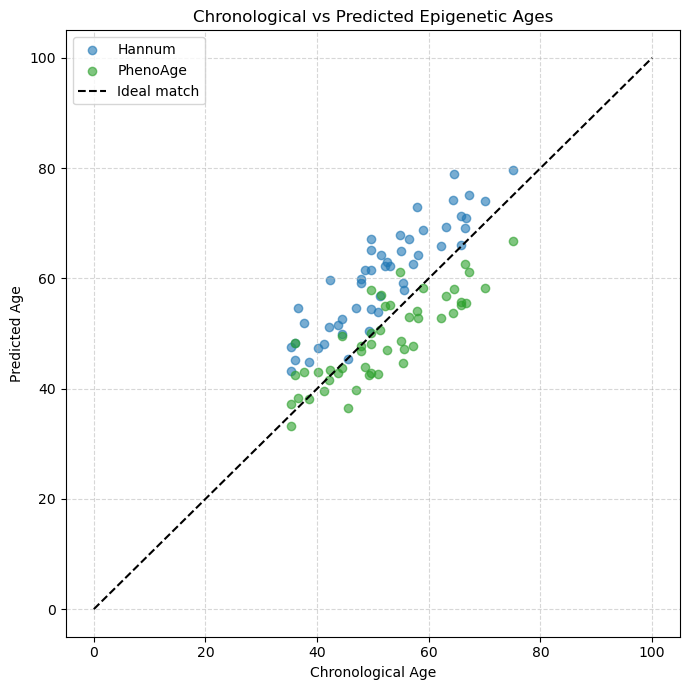

,Sample_ID,Chronological_Age,Hannum_Pred,PhenoAge_Pred
7471147090_R06C02,7471147090_R06C02,52.1,62.161594,54.942240
7471147041_R01C02,7471147041_R01C02,65.7,66.078615,55.658077
7471147036_R04C01,7471147036_R04C01,53.1,62.251005,55.124972
7471147072_R03C01,7471147072_R03C01,57.9,73.006205,54.018857
7471147062_R03C02,7471147062_R03C02,65.8,71.344777,55.172134
7471147004_R02C01,7471147004_R02C01,57.2,62.616863,47.679734
7471147027_R02C02,7471147027_R02C02,55.5,57.808245,47.152208
7471147004_R04C01,7471147004_R04C01,44.5,49.971046,49.513149
7471147092_R02C02,7471147092_R02C02,52.5,63.044093,47.010876
7471147006_R03C02,7471147006_R03C02,41.2,48.184973,39.654169


In [12]:
# Load FHE clients and servers
hannum_client = FHEModelClient(path_dir="fhe_hannum_model", key_dir="client_keys/")
hannum_server = FHEModelServer(path_dir="fhe_hannum_model")
hannum_server.load()
hannum_keys = hannum_client.get_serialized_evaluation_keys()

pheno_client = FHEModelClient(path_dir="fhe_phenoage_model", key_dir="client_keys/")
pheno_server = FHEModelServer(path_dir="fhe_phenoage_model")
pheno_server.load()
pheno_keys = pheno_client.get_serialized_evaluation_keys()

# Prepare correctly sized input matrices
scaling_factor = 1000
X_hannum = (aligned_betas.loc[hannum_coefs.index, selected_ids].T.values * scaling_factor).astype(int)
X_phenoage = (aligned_betas.loc[phenoage_coefs.index, selected_ids].T.values * scaling_factor).astype(int)

# Run FHE inference
hannum_preds, phenoage_preds = [], []

for x_h, x_p in zip(X_hannum, X_phenoage):
    x_h = x_h.reshape(1, -1)
    x_p = x_p.reshape(1, -1)

    # Hannum inference
    enc_h = hannum_client.quantize_encrypt_serialize(x_h)
    out_h = hannum_server.run(enc_h, hannum_keys)
    pred_h = hannum_client.deserialize_decrypt_dequantize(out_h)[0]
    hannum_preds.append(pred_h)

    # PhenoAge inference
    enc_p = pheno_client.quantize_encrypt_serialize(x_p)
    out_p = pheno_server.run(enc_p, pheno_keys)
    pred_p = pheno_client.deserialize_decrypt_dequantize(out_p)[0]
    phenoage_preds.append(pred_p)

# Add predictions to DataFrame
merged_df["Hannum_Pred"] = hannum_preds
merged_df["PhenoAge_Pred"] = phenoage_preds

# Show results
merged_df[["Sample_ID", "Chronological_Age", "Hannum_Pred", "PhenoAge_Pred"]].head(25)
compare_ages_from_merged_df(merged_df)